# Part 1. When people write Yelp reviews for restaurants, which aspects do they value more?


Food, ambience, parking, service or wait time? How do the reviewers weigh these categories, 
and how are they reflected on the overall star ratings? My guess to this question is that food quality 
would be the most important thing when making an evaluation for a restaurant. Even if other aspects 
such as service and parking are not that great, as long as they are not horrible that it takes 
half an hour to find a parking spot or place an order, it should not affect the overall ratings. 
I am also curious to find out the line between what's acceptable or not in those categories. 
To what extent can people tolerate? 


## Background
It is obvious that star ratings are the ones that influence first impression the most on Yelp; an extra half-star rating causes restaurants to sell out 19 percentage points (49%) more frequently (Anderson). This shows how important they are when shaping a restaurants' impressions, and because they can influence the newcomers to the restaurant so much, they need to be presented more accurately. 

But since the yelp reviews are rounded up by half stars, a restaurant with score of 3.45 and another with a score of 3.52 would be rounded to 3.0 and 3.5 stars, respectively. Though their raw scores differ by .07, their official ratings differ by 0.5 and their star colors would also be different – visually affecting the users when they judge a restaurant solely on the star rating.

Data from Yelp Dataset Challenge will be used (https://www.yelp.com/dataset_challenge).


## 1. Data Analysis - Exploring the data

Initial analysis: Separate reviews by using individual words as tokens. Get simple frequency of each word after stemming and removing stop words to cluster similar words with different forms. 

There are five different datasets provided by Yelp as JSON files: business, checkin, review, tip, and user. I will be using "review" first to see the initial results. 


In [5]:
import json
import os
import random
import nltk
import pickle

# Weird unicode error processing some of the tweets
import re
import sys

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

dir = os.path.abspath('__file__' + '/../')

file_name = 'yelp_academic_dataset_business.json'
full_name = os.path.join(dir, file_name)


def load_business_data(fname):

    print("processing reviews...", '\n')
    
    count = 0
    star_dict = {}
    food = []
    
    with open(fname,'r', encoding='utf-8') as f:
        for row in f:
            
            business = json.loads(row)
            star = float(business['stars'])
                
            # see how many reviews there are for each star rating
            if(star in star_dict):
                star_dict[star] += 1
            else:
                star_dict[star] = 1
                
            cate = business['categories']
            for w in cate:
                if(w == 'Restaurants'):
                    food.append(business['business_id'])
                    break
                
    # print results
    for key in sorted(star_dict):
        print ("%s: %s" % (key, star_dict[key]))

    print("num of restaurants: ",len(food))
    print("done")
    
    return food

restaurant_ids = load_business_data(full_name) 


processing reviews... 

1.0: 911
1.5: 1603
2.0: 3312
2.5: 6626
3.0: 9988
3.5: 15468
4.0: 16142
4.5: 12226
5.0: 11169
num of restaurants:  25071
done


### Loading Data from Yelp
Separated review text according to their star rating to see general distribution

In [6]:



def load_exp_reviews(fname, res_list):

    print("processing reviews...", '\n')
    
    if not os.path.exists(fname):

        file_name = 'yelp_academic_dataset_review.json'
        full_name = os.path.join(dir, file_name)
    

        # Identify stopwords to remove
        stop_words = set(stopwords.words('english'))

        # create stemmer to stem words
        stemmer=SnowballStemmer("english")

        # [total, one, two, three, four, five]
        count_stars = [0] * 6

        # store review text for each star rating separately
        one_star = []
        two_star = []
        three_star = []
        four_star = []
        five_star = []


        with open(full_name,'r', encoding='utf-8') as f:
            for row in f:

                # only load first 50000 for now
                if(count_stars[0] > 49999):
                    break

                review = json.loads(row)

                if(review['business_id'] in res_list):

                    # count how many reviews have one star, two stars, etc.
                    star_rating = int(review["stars"])
                    count_stars[star_rating]  += 1
                    count_stars[0] += 1

                    review_text = review["text"]
                    review_text = review_text.lower()

                    review_text = re.sub(r"[\.]{3,}", ' ', review_text) # remove ...
                    review_text = re.sub(r"[()]", '', review_text) # remove ()

                    # remove stop words
                    review_text = ' '.join([word for word in review_text.split() if word not in stop_words])

                    # stem words
                    review_words=str.split(str(review_text),' ')

                    for word in review_words:
                        stemmed = stemmer.stem(word)
                        if (len(stemmed)>0):
                            if (star_rating == 1):
                                one_star.append(stemmed)
                            if (star_rating == 2):
                                two_star.append(stemmed)
                            if (star_rating == 3):
                                three_star.append(stemmed)
                            if (star_rating == 4):
                                four_star.append(stemmed)
                            if (star_rating == 5):
                                five_star.append(stemmed)
        with open(fname, 'wb') as f:
            pickle.dump([count_stars, one_star, two_star, three_star, four_star, five_star], f)
            
    else:
        print ('Loading processed reviews...')
        with open(fname,'rb') as f:
            count_stars, one_star, two_star, three_star, four_star, five_star = pickle.load(f)
    
    
    #print(tokens, "\n")
    #print(string)
    print (count_stars)
    print ("done - loaded exp reviews")
    
    return count_stars, one_star, two_star, three_star, four_star, five_star
    
file_name='loaded_tweets.pickle'
fname = os.path.join(dir, file_name)

count_stars, one_star, two_star, three_star, four_star, five_star = load_exp_reviews(fname, restaurant_ids)



processing reviews... 

Loading processed reviews...
[50000, 4896, 5203, 7789, 15944, 16168]
done - loaded exp reviews


First 50,000 had distribution of [5796, 4980, 7791, 15170, 16263] for one, two, three, four and five stars respectively.


### Convert raw count into percentage

In [7]:
total = count_stars[0]
star_percentage = []
#print(count_stars)

for x in count_stars[1:]:
    star_percentage.append("%.2f" %(x/total * 100))
    
print(star_percentage)

['9.79', '10.41', '15.58', '31.89', '32.34']


Out of the first 50000 reviews, more than half (64%) of them were four or five star reviews. 

When Yelp users visit a restaurant for the first time, they are more likely to choose one with the highest rating. And because highly rated restaurants are more likely to be visited, the first-timers are likely to have a positive experience and leave a positive rating. 

## 2. Generating word cloud

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread

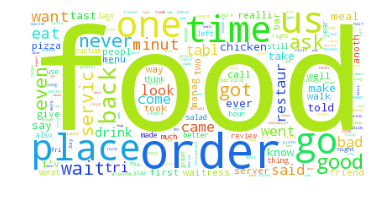

In [9]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 100)

dir = os.path.abspath('__file__' + '/../')

font_file_name = 'DroidSansMono.ttf'
font_full_name = os.path.join(dir, font_file_name)

# read the mask image
# taken from
# https://image.freepik.com/free-icon/apple-black-silhouette-with-a-leaf_318-62258.png

image_file_name = 'img/apple.jpg'
mask = imread(os.path.join(dir, image_file_name))


# for each star reviews - reformat words from review
def convert_to_string(review_list):
    review_string = ""
    for review in review_list:
        
        review_words=str.split(str(review),' ')

        for word in review_words:
            review_string += word
            review_string += " "
    
    return review_string

string_one = convert_to_string(one_star)
string_two = convert_to_string(two_star)
string_three = convert_to_string(three_star)
string_four = convert_to_string(four_star)
string_five = convert_to_string(five_star)

# Attempted to use apple image as a mask and also turn it into black and white (greyscale), 
# but the resulting word cloud was harder to read than the original
'''
wordcloud = WordCloud(mask=mask, font_path=font_full_name, margin = 10, background_color='white', random_state = 1).generate(string_one)
# store to jpg file
wordcloud.to_file("img/apple_cloud.png")
'''

wordcloud = WordCloud(background_color='white').generate(string_one)

#wordcloud = WordCloud(background_color='white').generate(string_two)

#wordcloud = WordCloud(background_color='white').generate(string_three)

#wordcloud = WordCloud(background_color='white').generate(string_four)

#wordcloud = WordCloud(background_color='white').generate(string_five)


# Open a plot of the generated image.
#plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
plt.imshow(wordcloud)
wordcloud.to_file("wordcloud_star.png")
plt.axis("off")
plt.show()



As expected, "food" was the main topic across all the star ratings. 

## 3. Counting frequency of words
We will use Scikit-learn's CountVectorizer for n-gram extraction

In [10]:
from collections import Counter
from nltk import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer

def calc_freq(words):
    
    freq_dist = nltk.FreqDist(words)
    word_features = freq_dist.keys()

    #print (freq_dist.values())
    
    vocab = sorted(freq_dist)
    
calc_freq(one_star)

# Part 2. Menu for Yelp 

## The photos on Yelp website are categorized into Food, Drinks, Inside, Outside and Menu. I noticed that the categorization captures the content of the photo pretty accurately and thought the photos in the Menu category can be used more efficiently, together with the photos in Food and Drinks categories.

When people visit a restaurant, it is not always easy for them to choose what to get. They don't know how big serving sizes are or what the food actually looks like; even with the description that the restaurant's menu provides, it is not an easy task to visualize a foreign food. 

So they use Yelp app on their phone, trying to see pictures of food that the previous visitors have uploaded. With this last minute serach, they try to get every bit of information they can get before they waste their time and money on foreign food. But this is not as easy as it seems. The photos don't always have captions that describe what the food actually is, and they are in seemingly random order that doesn't separate appetizers from entrees. Among tens and hundreds of photos that they scroll through, there may, or may not, be the photo of the food they are looking for. 

This risky last-minute search can be improved if there is a menu tab for each restaurant's page that include the name, price, photos and reviews of the food. This feature does exist currently, but often times, it does not serve its true purpose. Some restaurants seem to have their menu separately on their own website, which involves extra steps for the users to click the link to see the menu which could also be in PDF file that they have to download. Some restaurant Yelp pages don't even have any information about their menu - the users have to solely rely on the photos to make their decision.

For some restaurants that do not have any info about their menu on Yelp page, but often times, they do have photos of the menu that users uploaded. They could be printed on paper, displayed on screen, or even written on the chalkboard. These photos could be converted into actual typed menu on the Yelp page. 

### Flowchart


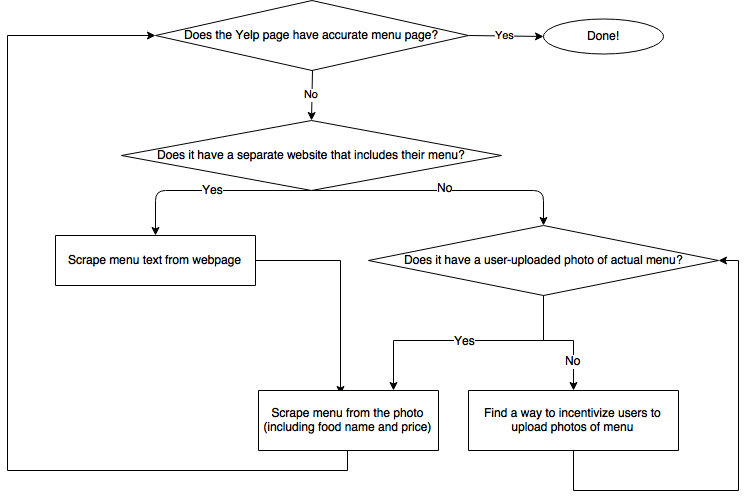

In [11]:
from IPython.display import Image
Image(filename='img/flowchart.png') 



# Part 3.  Finding correlation among randomly chosen attributes

1. City vs. Average star rating
2. Latitude vs. Average star rating
3. Longitude vs. Average star rating
4. Review count vs. Average star rating

## 1. City vs. Average star rating

In [12]:
from collections import defaultdict
from collections import OrderedDict

'''
output example:
dictionary {'city': [5.0, 4.5], 'city_2':[1.0, 2.5]}
'''
        
def city(fname, res_id):
    
    city_score_dict = {}
    
    with open(fname,'r', encoding='utf-8') as f:
        
        for row in f:
            
            business = json.loads(row)
            
            # if it's a restaurant
            if (business['business_id'] in res_id):
                
                # load neighborhood info and star
                city = business['city']
                star = float(business['stars'])
                                
                # add to dictionary of lists
                if city not in city_score_dict:  # new key?
                    city_score_dict[city] = []
                    city_score_dict[city].append(star)
                    #print(city, "new")
                else:
                    city_score_dict[city].append(star)
                    #print(city)
                    
    return city_score_dict
                
    
# calculate average rating for each city
def calc_avg(score_dict):
    avg_dict = {}
    
    for key, value in score_dict.items():
        
        #scores = score_dict.get(item)
        total = 0
        count = 0
        
        for s in value:
            count += 1
            total += s
            
        if(count >= 10):
            avg_dict[key] = total/count
    
    return avg_dict
    
dir = os.path.abspath('__file__' + '/../')

file_name = 'yelp_academic_dataset_business.json'
full_name = os.path.join(dir, file_name)      

restaurant_ids = load_business_data(full_name) 
city_score_dict = city(full_name, restaurant_ids)

avg_by_city = calc_avg(city_score_dict)

processing reviews... 

1.0: 911
1.5: 1603
2.0: 3312
2.5: 6626
3.0: 9988
3.5: 15468
4.0: 16142
4.5: 12226
5.0: 11169
num of restaurants:  25071
done


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


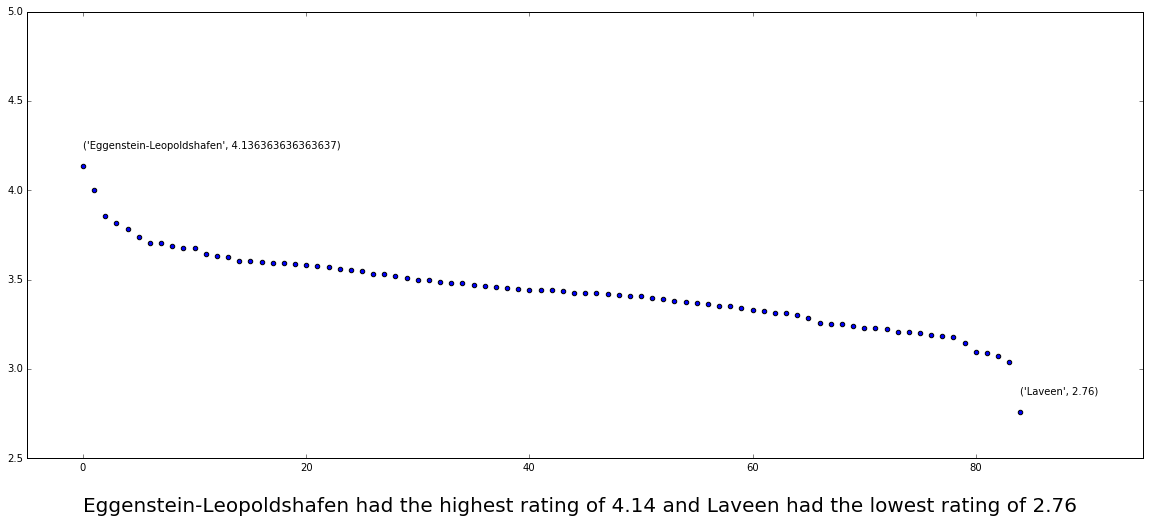

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 8.0)

sorted_list = [(k,v) for v,k in sorted( [(v,k) for k,v in avg_by_city.items()], reverse=True)]
#print(sorted_list)

import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)

t = list(range(len(sorted_list)))
s = []
for (key, coordinate) in sorted_list:
    s.append(coordinate)
    
line = ax.scatter(t, s)

xval = 0
yval = sorted_list[xval][1]
ax.annotate(sorted_list[0], xy=(xval,yval), xytext=(xval,yval+.1),)

xval = len(sorted_list)-1
yval = sorted_list[xval][1]
ax.annotate(sorted_list[len(sorted_list)-1], xy=(xval,yval), xytext=(xval,yval+.1))

caption = 'Eggenstein-Leopoldshafen had the highest rating of 4.14 and Laveen had the lowest rating of 2.76'

ax.set_ylim(2.5,5)
ax.set_xlim(-5,95)
ax.text(0,2.2,caption, size=20)

plt.show()


## 2. Latitude vs. Average star-rating

## References
1. M. Anderson and J. Magruder. “Learning from the Crowd.” The Economic Journal. 2011. 
2. wordcloud by A. Muller https://github.com/amueller/word_cloud